In [2]:
import torch
import torchvision as tv
import pandas as pd
import numpy as np
import time

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

In [125]:
BATCH_SIZE = 256

In [4]:
# train_dataset = tv.datasets.MNIST('.',train=True,transform=tv.transforms.ToTensor(),download=True)
train_dataset = tv.datasets.FashionMNIST('.',train=True,transform=tv.transforms.ToTensor(),download=True)
# https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html
# https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy
# test_dataset = tv.datasets.MNIST('.',train=False,transform=tv.transforms.ToTensor(),download=True)
test_dataset = tv.datasets.FashionMNIST('.',train=False,transform=tv.transforms.ToTensor(),download=True)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|███████████████████████████| 26421880/26421880 [00:58<00:00, 451361.00it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|█████████████████████████████████| 29515/29515 [00:00<00:00, 345354.90it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|█████████████████████████████| 4422102/4422102 [00:04<00:00, 891205.14it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████████████████████████████| 5148/5148 [00:00<00:00, 6397711.70it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [5]:
train.dataset[0][0].shape

torch.Size([1, 28, 28])

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
#https://stackoverflow.com/questions/63302534/how-to-write-torch-devicecuda-if-torch-cuda-is-available-else-cpu-as-a-f

In [89]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [78]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,10)
)

In [79]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [80]:
loss = torch.nn.CrossEntropyLoss()
trainer = torch.optim.SGD(model.parameters(),lr=0.01)
num_epochs = 10

In [96]:
def train_model(model,device,id_string=""):
    model.to(device)
    train_acc_list = []
    test_acc_list = []
    for ep in range(num_epochs):
        train_iters, train_passed = 0,0
        train_loss, train_acc = 0.,0.
        start = time.time()
        
        model.train()
        for X,y in train:
#             X.to(device)
#             y.to(device)
            y = moveTo(y, device)
            X = moveTo(X, device)
            trainer.zero_grad()
            y_pred = model(X)
            l = loss(y_pred,y)
            l.backward()
            trainer.step()
            train_loss += l.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item()
            train_iters += 1
            train_passed += len(X)
        train_acc_list.append(train_acc/train_passed)
#             train_acc_list.append(accuracy_score(y.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))
            
        test_iters, test_passed = 0,0
        test_loss, test_acc = 0.,0.
        model.eval()
        for X,y in test:
#             X.to(device)
#             y.to(device)
            y = moveTo(y, device)
            X = moveTo(X, device)
            y_pred = model(X)
            l = loss(y_pred,y)
            test_loss += l.item()
            test_acc += (y_pred.argmax(dim=1) == y).sum().item()
            test_iters += 1
            test_passed += len(X)
        test_acc_list.append(test_acc/test_passed)
            
        print("ep: {}, taked: {:.3f}, train_loss: {}, train_acc: {}, test_loss: {}, test_acc: {}".format(
        ep, time.time() - start, train_loss/train_iters, train_acc/train_passed, test_loss/test_iters,
            test_acc/test_passed))
    plt.plot(range(1,num_epochs+1),train_acc_list,label="train_acc")
    plt.plot(range(1,num_epochs+1),test_acc_list, label="test_acc")
    plt.xlabel("epoch num")
    plt.ylabel("accuracy")
    if id_string:
        id_string = "\n" + id_string
    plt.title("Accuracy evolution"+id_string)
    plt.legend()
    

ep: 0, taked: 7.993, train_loss: 0.8634154735727513, train_acc: 0.7046, test_loss: 0.8193751007318497, test_acc: 0.706
ep: 1, taked: 7.938, train_loss: 0.7704959978448583, train_acc: 0.7364166666666667, test_loss: 0.7498386636376381, test_acc: 0.736
ep: 2, taked: 7.665, train_loss: 0.7124005916270804, train_acc: 0.7591, test_loss: 0.70147455483675, test_acc: 0.7546
ep: 3, taked: 7.855, train_loss: 0.6698312513371731, train_acc: 0.7764, test_loss: 0.664828934520483, test_acc: 0.7714
ep: 4, taked: 8.370, train_loss: 0.6367155095364185, train_acc: 0.7891333333333334, test_loss: 0.636161919683218, test_acc: 0.7816
ep: 5, taked: 7.912, train_loss: 0.6102860159062324, train_acc: 0.7981, test_loss: 0.6133251413702965, test_acc: 0.7887
ep: 6, taked: 7.604, train_loss: 0.5888390553758499, train_acc: 0.8044833333333333, test_loss: 0.5948244698345662, test_acc: 0.7948
ep: 7, taked: 7.615, train_loss: 0.5711508116823562, train_acc: 0.80995, test_loss: 0.5795803613960743, test_acc: 0.799
ep: 8, tak

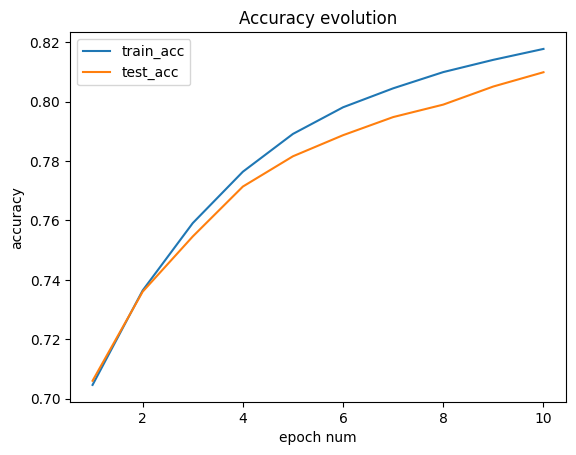

In [97]:
train_model(model, device)

In [59]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,10)
)
trainer = torch.optim.Adam(model.parameters(),lr=0.01)
train_acc_list = []
test_acc_list = []
train_model(model)

ep: 0, taked: 9.005, train_loss: 0.5329444674735374, train_acc: 0.8103, test_loss: 0.42734434828162193, test_acc: 0.8438
ep: 1, taked: 8.942, train_loss: 0.38121047958414606, train_acc: 0.8615166666666667, test_loss: 0.3954235278069973, test_acc: 0.8587
ep: 2, taked: 8.888, train_loss: 0.34790398497530756, train_acc: 0.8718333333333333, test_loss: 0.3906593151390553, test_acc: 0.8631
ep: 3, taked: 9.233, train_loss: 0.3277325375283018, train_acc: 0.8783, test_loss: 0.3728234488517046, test_acc: 0.8683
ep: 4, taked: 9.530, train_loss: 0.3120867377900063, train_acc: 0.88515, test_loss: 0.40051930733025076, test_acc: 0.8593
ep: 5, taked: 8.985, train_loss: 0.299156957737943, train_acc: 0.88785, test_loss: 0.3909718405455351, test_acc: 0.8652
ep: 6, taked: 8.723, train_loss: 0.2891904359168195, train_acc: 0.89195, test_loss: 0.3876113023608923, test_acc: 0.8672
ep: 7, taked: 8.791, train_loss: 0.2845724635935844, train_acc: 0.89465, test_loss: 0.3756526384502649, test_acc: 0.8684
ep: 8, ta

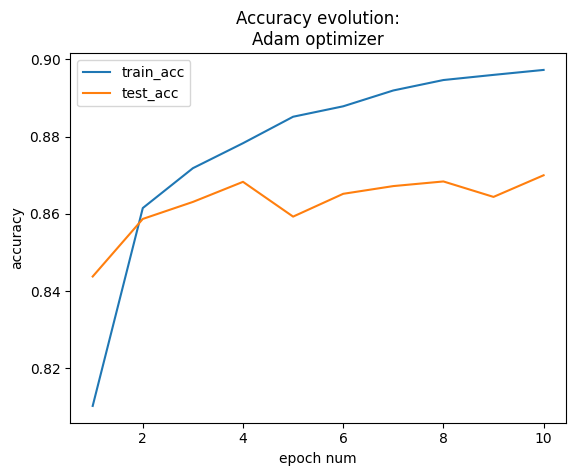

In [60]:
plt.plot(range(1,num_epochs+1),train_acc_list,label="train_acc")
plt.plot(range(1,num_epochs+1),test_acc_list, label="test_acc")
plt.xlabel("epoch num")
plt.ylabel("accuracy")
plt.title("Accuracy evolution:\nAdam optimizer")
plt.legend()

ep: 0, taked: 11.103, train_loss: 0.6436093086891986, train_acc: 0.7665833333333333, test_loss: 0.44425555467605593, test_acc: 0.8381
ep: 1, taked: 11.488, train_loss: 0.38814657095898975, train_acc: 0.8575666666666667, test_loss: 0.40101253017783167, test_acc: 0.8533
ep: 2, taked: 11.526, train_loss: 0.36374844724827626, train_acc: 0.8660166666666667, test_loss: 0.383295589312911, test_acc: 0.8638
ep: 3, taked: 11.450, train_loss: 0.34330471170709487, train_acc: 0.8735333333333334, test_loss: 0.4065197672694921, test_acc: 0.8538
ep: 4, taked: 11.476, train_loss: 0.3345606710682524, train_acc: 0.8778833333333333, test_loss: 0.3823062226176262, test_acc: 0.8637
ep: 5, taked: 11.322, train_loss: 0.3182884028617372, train_acc: 0.8828, test_loss: 0.38943844586610793, test_acc: 0.8638
ep: 6, taked: 11.489, train_loss: 0.3044519681879815, train_acc: 0.8867666666666667, test_loss: 0.383934535831213, test_acc: 0.8618
ep: 7, taked: 11.352, train_loss: 0.30413607396978015, train_acc: 0.8878, tes

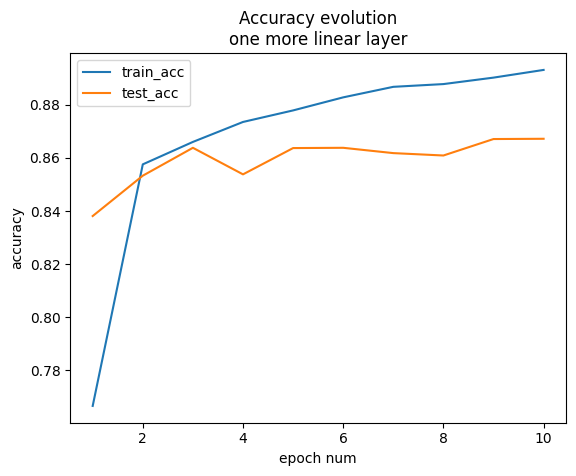

In [66]:
model2 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)
trainer = torch.optim.Adam(model2.parameters(),lr=0.01)
train_model(model2, "one more linear layer")

ep: 0, taked: 11.589, train_loss: 0.47259942343894473, train_acc: 0.82685, test_loss: 0.4400351881980896, test_acc: 0.8329
ep: 1, taked: 11.282, train_loss: 0.3692161575910893, train_acc: 0.8647333333333334, test_loss: 0.44770453609526156, test_acc: 0.84
ep: 2, taked: 11.886, train_loss: 0.34255881544123307, train_acc: 0.87435, test_loss: 0.40675058122724295, test_acc: 0.8514
ep: 3, taked: 11.971, train_loss: 0.31632334203162094, train_acc: 0.8837333333333334, test_loss: 0.38504653237760067, test_acc: 0.8593
ep: 4, taked: 11.857, train_loss: 0.3008813059710442, train_acc: 0.8883166666666666, test_loss: 0.3923351842910051, test_acc: 0.8619
ep: 5, taked: 12.023, train_loss: 0.2807235061488253, train_acc: 0.8967, test_loss: 0.3583193227648735, test_acc: 0.8711
ep: 6, taked: 11.815, train_loss: 0.2697354297054575, train_acc: 0.8997333333333334, test_loss: 0.36913477089256047, test_acc: 0.8747
ep: 7, taked: 11.460, train_loss: 0.26056830876685205, train_acc: 0.9032166666666667, test_loss: 0

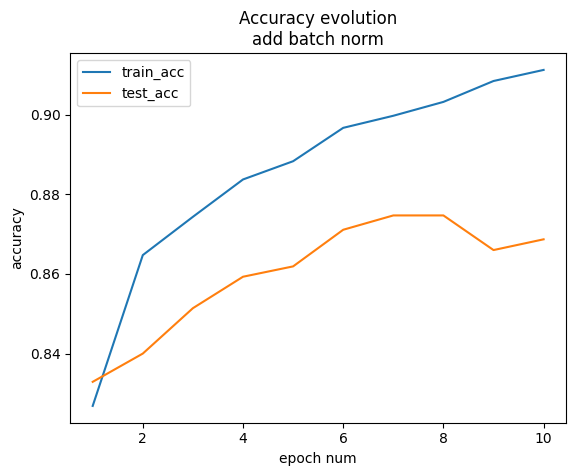

In [67]:
model3 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(256),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(128),
    torch.nn.Linear(128, 10)
)
trainer = torch.optim.Adam(model3.parameters(),lr=0.01)
train_model(model3, "add batch norm")

ep: 0, taked: 9.168, train_loss: 0.4786546768026149, train_acc: 0.8284833333333333, test_loss: 0.4475962188094854, test_acc: 0.843
ep: 1, taked: 8.856, train_loss: 0.38262031230520693, train_acc: 0.86215, test_loss: 0.4250288851559162, test_acc: 0.8488
ep: 2, taked: 9.131, train_loss: 0.34926563431607915, train_acc: 0.87345, test_loss: 0.4068574920296669, test_acc: 0.8551
ep: 3, taked: 8.821, train_loss: 0.324906854046152, train_acc: 0.8813166666666666, test_loss: 0.41570817641913893, test_acc: 0.854
ep: 4, taked: 8.807, train_loss: 0.3098766154431282, train_acc: 0.8869166666666667, test_loss: 0.38466507792472837, test_acc: 0.8657
ep: 5, taked: 9.565, train_loss: 0.29953429464330067, train_acc: 0.8896, test_loss: 0.3863376758992672, test_acc: 0.8627
ep: 6, taked: 9.381, train_loss: 0.28616186849614406, train_acc: 0.8945666666666666, test_loss: 0.4017435047775507, test_acc: 0.8568
ep: 7, taked: 9.134, train_loss: 0.2819759983965691, train_acc: 0.8963, test_loss: 0.4289213489741087, test

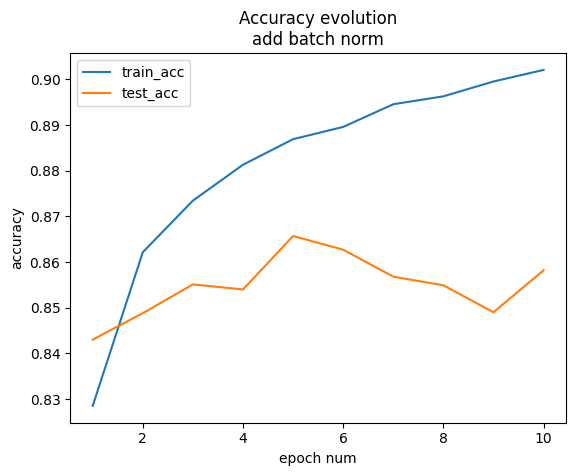

In [68]:
model4 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784,256),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(256),
    torch.nn.Linear(256,10)
)
trainer = torch.optim.Adam(model4.parameters(),lr=0.01)
train_model(model4, "add batch norm")

In [133]:
BATCH_SIZE = 128
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

ep: 0, taked: 9.282, train_loss: 1.0472931431046426, train_acc: 0.7332833333333333, test_loss: 0.6754277808756768, test_acc: 0.8083
ep: 1, taked: 9.157, train_loss: 0.5966803770838007, train_acc: 0.8249333333333333, test_loss: 0.5086546736427501, test_acc: 0.8354
ep: 2, taked: 9.147, train_loss: 0.48072012165970385, train_acc: 0.8479, test_loss: 0.4449299008031435, test_acc: 0.8505
ep: 3, taked: 9.280, train_loss: 0.4227640758445268, train_acc: 0.8612666666666666, test_loss: 0.4110948085030423, test_acc: 0.8574
ep: 4, taked: 9.466, train_loss: 0.38366955315380463, train_acc: 0.87235, test_loss: 0.3881212706807293, test_acc: 0.8646
ep: 5, taked: 9.095, train_loss: 0.3540355080861781, train_acc: 0.88145, test_loss: 0.3766857300755344, test_acc: 0.8678
ep: 6, taked: 9.091, train_loss: 0.3337240863774123, train_acc: 0.8874166666666666, test_loss: 0.3647812348377856, test_acc: 0.8721
ep: 7, taked: 9.149, train_loss: 0.3156252053500747, train_acc: 0.8920666666666667, test_loss: 0.35194772991

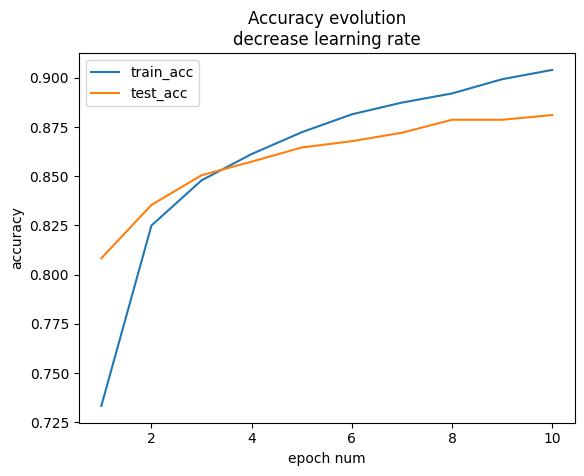

In [142]:
model5 = torch.nn.Sequential(
    torch.nn.Flatten(),
#     torch.nn.Dropout(0.1),
    torch.nn.Linear(784, 512),
    torch.nn.BatchNorm1d(512),
    torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(512),
    torch.nn.Linear(512, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(256),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(256, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(128),
    torch.nn.Linear(128, 64),
    torch.nn.BatchNorm1d(64),
    torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(64),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(64, 10)
)
trainer = torch.optim.SGD(model5.parameters(),lr=0.005)
train_model(model5, device,"decrease learning rate")